In [1]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

from IPython.display import Image

In [2]:
class WeatherResponse(BaseModel):
    """Respond to the user with this"""
    temperature: float = Field(description="The temperature in fahrenheit")
    wind_directon: str = Field(description="The direction of the wind in abbreviated form")
    wind_speed: float = Field(description="The speed of the wind in km/h")

# Inherit 'messages' key from MessagesState, which is a list of chat messages 
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: WeatherResponse

@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It is cloudy in NYC, with 5 mph winds in the North-East direction and a temperature of 70 degrees"
    elif city == "sf":
        return "It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction"
    else:
        raise AssertionError("Unknown city")

tools = [get_weather]

In [3]:
model = ChatOllama(model="qwen2.5:14b", 
                   base_url="http://10.127.127.4:11434",
                   temperature=0)




In [4]:
model_with_tools = model.bind_tools([get_weather])
model_with_structured_output = model.with_structured_output(WeatherResponse)

In [5]:
# Force the model to use tools by passing tool_choice="any"    
model_with_response_tool = model.bind_tools([get_weather, WeatherResponse],tool_choice="any")

# Define the function that calls the model
def call_model(state: AgentState):
    response = model_with_response_tool.invoke(state['messages'])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the function that responds to the user
def respond(state: AgentState):
    # Construct the final answer from the arguments of the last tool call
    response = WeatherResponse(**state['messages'][-1].tool_calls[0]['args'])
    # We return the final answer
    return {"final_response": response}

# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if len(last_message.tool_calls) == 1 and last_message.tool_calls[0]['name'] == "WeatherResponse":
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

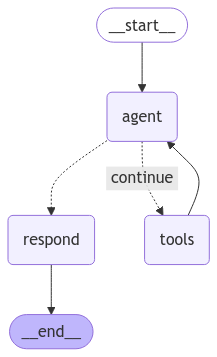

In [6]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [7]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [8]:
inputs = {"messages": [("user", "what is the weather in sf")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (dab27ea5-8802-490c-a6a8-a9e0f6827e81)
 Call ID: dab27ea5-8802-490c-a6a8-a9e0f6827e81
  Args:
    city: sf
================================= Tool Message =================================
Name: get_weather

It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction
================================== Ai Message ==================================

The weather in San Francisco (SF) is currently 75°F and sunny. The wind is blowing from the South-East at a speed of 3 mph.
================================== Ai Message ==================================

The weather in San Francisco (SF) is currently 75°F and sunny. The wind is blowing from the South-East at a speed of 3 mph.
================================== Ai Message ==================================
======